In [25]:
import cv2
import glob
import numpy as np

In [51]:
from keras.layers import Input, merge, Concatenate, Dense, Dropout, Conv2D, Add, Dot, Lambda, Conv2DTranspose, Dot, Activation, Reshape, BatchNormalization, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Multiply, LeakyReLU, Flatten, MaxPool2D 
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.models import Model
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [44]:
img_paths = glob.glob('./train2017/00000000[012345][0123456789][0123456789][0123456789].jpg')

In [45]:
len(img_paths)

1168

In [50]:
for img_path in img_paths:
    img = cv2.imread(img_path)
    x,y,_ = img.shape
    margin = (y-x)//2
    #print(img_path.split('/')[-1])
    img = img[:,margin:y-margin]
    img = cv2.resize(img, (128,128))
    cv2.imwrite('./cleaned-data/' + img_path.split('/')[-1], img)

In [197]:
def build_encoder(input_shape, name='encoder'):
    input_layer = Input(shape=input_shape)
    
    encode_channels = [8, 16, 32, 64]
    
    for index, channel in enumerate(encode_channels):
        encoder_block = Conv2D(channel, 3, padding='same', activation='relu')(input_layer if index == 0 else encoder_block)            
        encoder_block = Conv2D(channel, 3, padding='same', activation='relu')(encoder_block)
        encoder_block = MaxPool2D()(encoder_block)
        
    
#     # first encoding block
#     encode1 = Conv2D(8, 3, padding='same', activation='relu')(input_layer)
#     encode1 = Conv2D(8, 3, padding='same', activation='relu')(encode1)
#     encode1 = MaxPool2D()(encode1)
    
#     # Second encoding block
#     encode2 = Conv2D(16, 3, padding='same', activation='relu')(encode1)
#     encode2 = Conv2D(16, 3, padding='same', activation='relu')(encode2)
#     encode2 = MaxPool2D()(encode2)
    
#     # Third encoding block
#     encode3 = Conv2D(32, 3, padding='same', activation='relu')(encode2)
#     encode3 = Conv2D(32, 3, padding='same', activation='relu')(encode3)
#     encode3 = MaxPool2D()(encode3)
    
    
    output_layer = encoder_block
    return Model(input_layer, output_layer, name=name)

In [210]:
encoder = build_encoder((128,128,3))
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 128, 128, 8)       224       
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 128, 128, 8)       584       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 64, 64, 16)        1168      
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 32, 32, 16)        0         
__________

In [220]:
def build_decoder(input_shape, name='decoder'):
    input_layer = Input(shape=input_shape)
    
    input_layer = Input(shape=input_shape)
    
    decode_channels = [64, 32, 16, 8]
    
    for index, channel in enumerate(decode_channels):
        decoder_block = UpSampling2D()(input_layer if index == 0 else decoder_block)
        decoder_block = Conv2D(channel, 3, padding='same', activation='relu')(decoder_block)            
        decoder_block = Conv2D(channel, 3, padding='same', activation='relu')(decoder_block)
    

    
#     # first decoding block
#     decode1 = UpSampling2D()(input_layer)
#     decode1 = Conv2D(16, 3, padding='same', activation='relu')(decode1)
#     decode1 = Conv2D(16, 3, padding='same', activation='relu')(decode1)
    
    
#     # Second decoding block
#     decode2 = UpSampling2D()(decode1)
#     decode2 = Conv2D(8, 3, padding='same', activation='relu')(decode2)
#     decode2 = Conv2D(8, 3, padding='same', activation='relu')(decode2)
    
    
#     # Third decoding block
#     decode3 = UpSampling2D()(decode2)
#     decode3 = Conv2D(4, 3, padding='same', activation='relu')(decode3)
#     decode3 = Conv2D(3, 3, padding='same', activation='relu')(decode3)
    
    
    output_layer = Conv2D(3, 3, padding='same', activation='relu')(decoder_block)
    return Model(input_layer, output_layer, name=name)

In [221]:
decoder = build_decoder((8,8,64))
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        (None, 8, 8, 64)          0         
_________________________________________________________________
up_sampling2d_43 (UpSampling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_175 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_176 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
up_sampling2d_44 (UpSampling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 32, 32, 32)        9248      
__________

In [222]:
def build_autoencoder():
    input_img = Input(shape=(128,128,3))
    latent_representation = encoder(input_img)
    decoded_img = decoder(latent_representation)
    autoencoder = Model(input_img, decoded_img, name="autoencoder")
    return autoencoder

In [223]:
autoencoder = build_autoencoder()

In [224]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
encoder (Model)              (None, 8, 8, 64)          73608     
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       110475    
Total params: 184,083
Trainable params: 184,083
Non-trainable params: 0
_________________________________________________________________


In [226]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [103]:
def data_loader(file_path):
    img_paths = glob.glob(file_path + '/*')
    data = []
    for img_path in img_paths:
        
        data.append(cv2.imread(img_path) / 255.0)
    return np.array(data)

In [104]:
X = data_loader('./cleaned-data/')

In [133]:
np.shape(X)
subset_X = X[:100]

In [249]:
history = autoencoder.fit(subset_X,subset_X, epochs=100, batch_size=25, shuffle=True)

Epoch 1/100
100/100 [==============================] - 4s 42ms/step - loss: 0.0087 - acc: 0.6608
Epoch 2/100
100/100 [==============================] - 4s 41ms/step - loss: 0.0088 - acc: 0.6573
Epoch 3/100
100/100 [==============================] - 4s 41ms/step - loss: 0.0088 - acc: 0.6653
Epoch 4/100
100/100 [==============================] - 4s 41ms/step - loss: 0.0087 - acc: 0.6711
Epoch 5/100
100/100 [==============================] - 4s 41ms/step - loss: 0.0088 - acc: 0.6657
Epoch 6/100
100/100 [==============================] - 4s 43ms/step - loss: 0.0088 - acc: 0.6616
Epoch 7/100
100/100 [==============================] - 4s 43ms/step - loss: 0.0087 - acc: 0.6534
Epoch 8/100
100/100 [==============================] - 4s 44ms/step - loss: 0.0085 - acc: 0.6685
Epoch 9/100
100/100 [==============================] - 4s 44ms/step - loss: 0.0086 - acc: 0.6716
Epoch 10/100
100/100 [==============================] - 4s 44ms/step - loss: 0.0085 - acc: 0.6672
Epoch 11/100
100/100 [=======

100/100 [==============================] - 5s 51ms/step - loss: 0.0085 - acc: 0.6719
Epoch 85/100
100/100 [==============================] - 5s 49ms/step - loss: 0.0085 - acc: 0.6629
Epoch 86/100
100/100 [==============================] - 5s 49ms/step - loss: 0.0085 - acc: 0.6647
Epoch 87/100
100/100 [==============================] - 5s 47ms/step - loss: 0.0085 - acc: 0.6628
Epoch 88/100
100/100 [==============================] - 5s 47ms/step - loss: 0.0085 - acc: 0.6638
Epoch 89/100
100/100 [==============================] - 5s 45ms/step - loss: 0.0085 - acc: 0.6546
Epoch 90/100
100/100 [==============================] - 4s 43ms/step - loss: 0.0085 - acc: 0.6541
Epoch 91/100
100/100 [==============================] - 4s 43ms/step - loss: 0.0086 - acc: 0.6653
Epoch 92/100
100/100 [==============================] - 4s 44ms/step - loss: 0.0085 - acc: 0.6611
Epoch 93/100
100/100 [==============================] - 4s 44ms/step - loss: 0.0085 - acc: 0.6546
Epoch 94/100
100/100 [===========

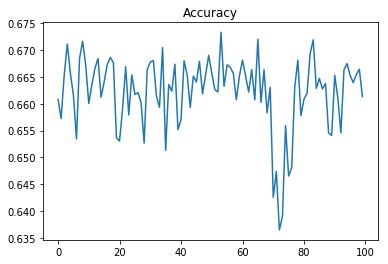

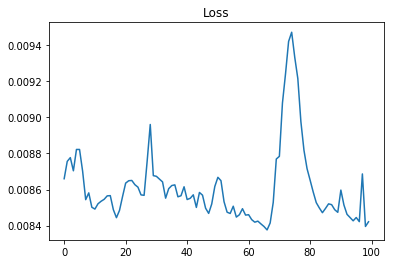

In [256]:
plt.plot(history.history['acc'])
plt.title("Accuracy")
plt.show()
plt.plot(history.history['loss'])
plt.title("Loss")
plt.show()


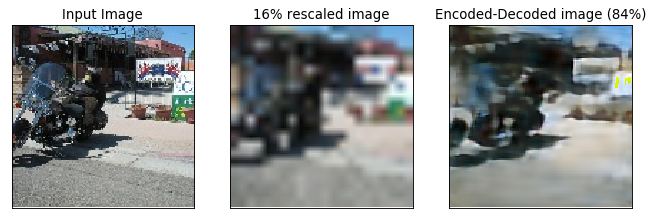

In [250]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
def rgb_imshow(img):
    plt.imshow(cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    #plt.show()

img_index = 5
img_input = subset_X[img_index]
plt.subplot(1,3,1)
plt.title("Input Image")
rgb_imshow(img_input)
plt.xticks([])
plt.yticks([])
scaled_img = cv2.resize((img_input*255).astype(np.uint8), (22,22))
scaled_img = cv2.resize(scaled_img, (128,128))
plt.subplot(1,3,2)
plt.title("16% rescaled image")
plt.imshow(cv2.cvtColor(scaled_img, cv2.COLOR_BGR2RGB))
#plt.show()
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,3)
plt.title("Encoded-Decoded image (84%)")
decoded_img = autoencoder.predict(np.array([img_input]))[0]

rgb_imshow(decoded_img)


plt.xticks([])
plt.yticks([])
plt.show()



In [198]:
build_encoder((128,128,3)).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 128, 128, 8)       224       
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 128, 128, 8)       584       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 32, 32, 16)        0         
__________

In [206]:
build_decoder((8,8,64)).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 8, 8, 64)          0         
_________________________________________________________________
up_sampling2d_25 (UpSampling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
up_sampling2d_26 (UpSampling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 32, 32, 32)        9248      
__________

In [257]:
autoencoder.save('autoencoder.h5')

In [252]:
code = encoder.predict(np.array([img_input]))[0]

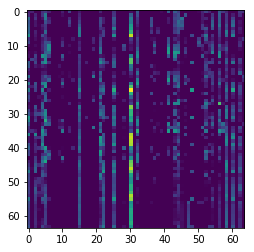

In [255]:
plt.imshow(np.reshape(code, (64,64)))

In [258]:
decoded_code = decoder.predict(np.array([code]))[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


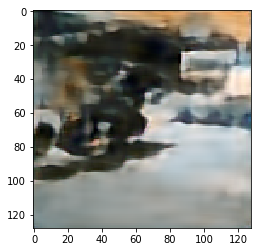

In [259]:
plt.imshow(decoded_code)